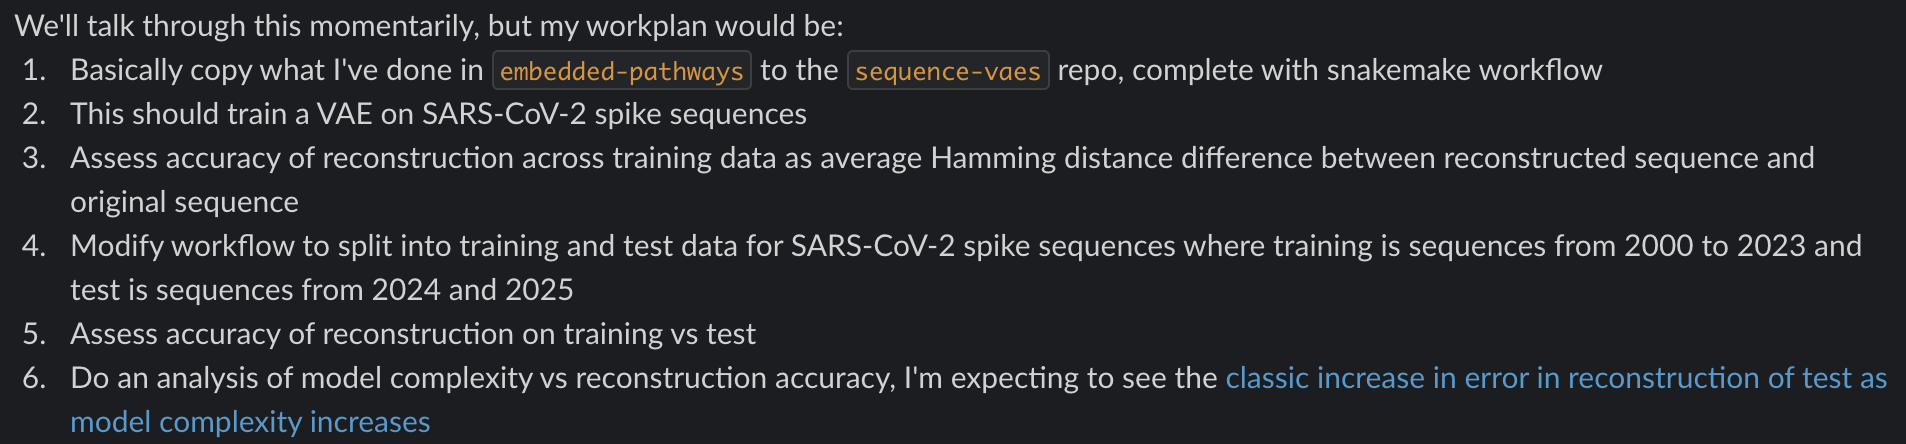

In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [2]:
# path to sequence_vaes directory
# abspath = "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
abspath = ".."

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
import json

# path to sequence_vaes directory and pip install
# %cd "/content/drive/MyDrive/bedford_lab/code/seq_vaes"
# !pip install -r requirements.txt

In [4]:
sys.path.append(abspath)
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import bedford_code.models_bedford as bedford

In [5]:
BATCH_SIZE = 64

# "data" directory is generated as shown in README.md file
dataset = DNADataset(f"{abspath}/data/training_spike.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## loss figures

In [98]:
train_logs = []
valid_logs = []

abspath = "./results"
# abspath = "./bedford_code/results_bedford"

N=1
with open(f"{abspath}/train_logs.json", "r") as f:
    train_logs = json.load(f)[N:]

with open(f"{abspath}/valid_logs.json","r") as f:
    valid_logs = json.load(f)[N:]

loss_X = list(range(N,len(valid_logs)+N, 1))

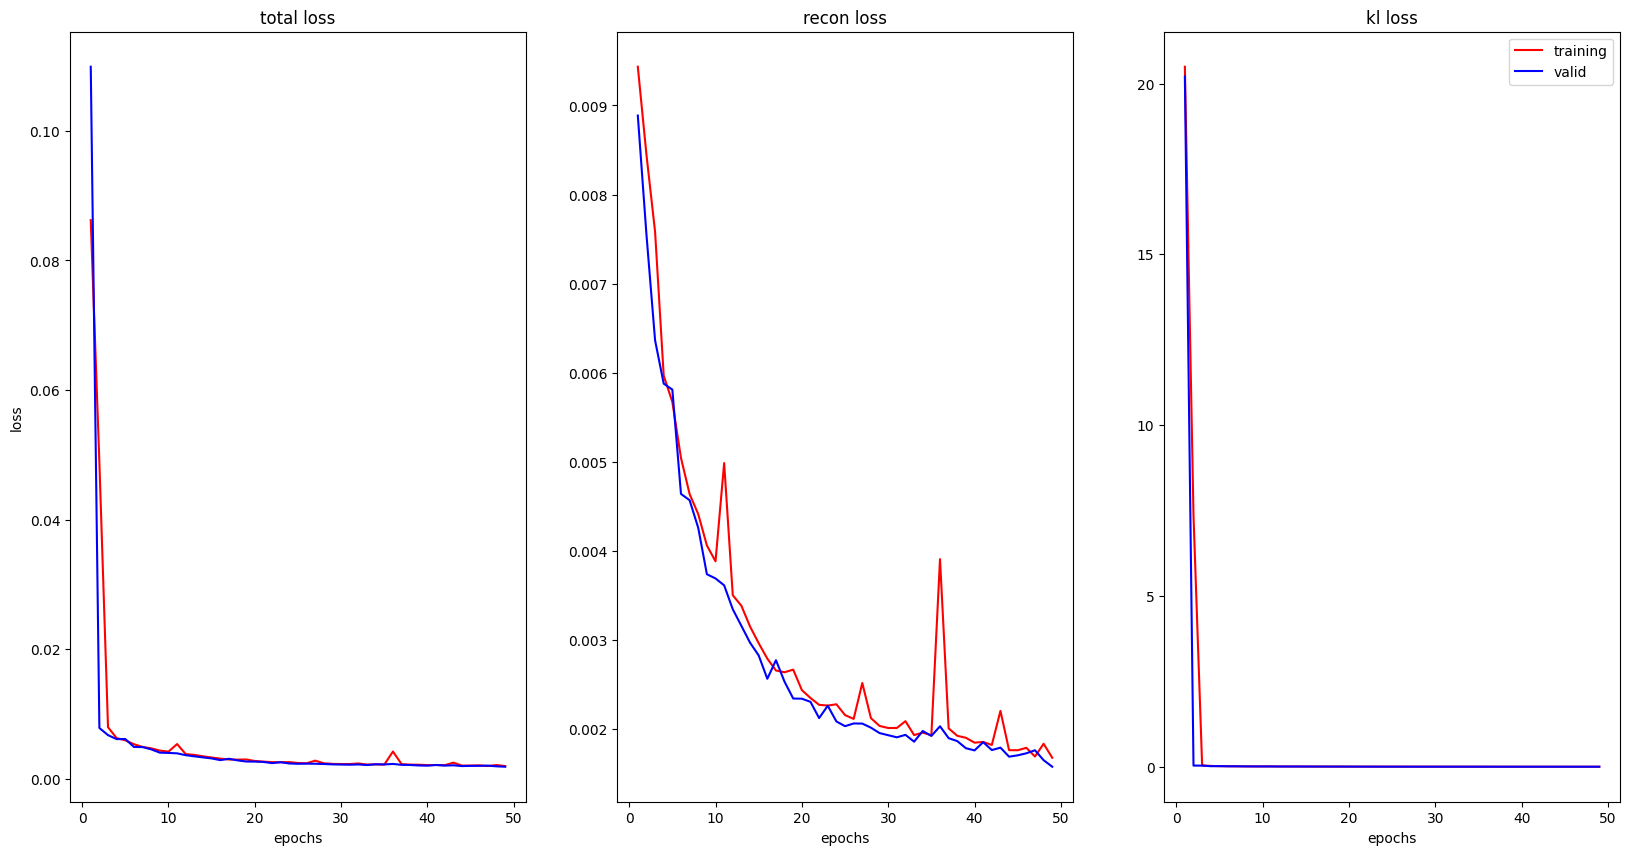

In [99]:
labels = ["total", "recon", "kl"]
colors = ["red", "blue"]

fig,arr = plt.subplots(1,3,figsize=(20,10))

N = len(train_logs)
for i in range(3):
    arr[i].plot(loss_X, [x[i] for x in train_logs], color=colors[0], label="training")
    arr[i].plot(loss_X, [x[i] for x in valid_logs], color=colors[1], label="valid")
    arr[i].set_title("%s loss"%labels[i])
    arr[i].set_xlabel("epochs")
    if i == 0:
        arr[i].set_ylabel("loss")

plt.legend()
fig.show()

## Embedding space Visualizations

In [7]:
input_dim = len(ALPHABET) * SEQ_LENGTH
# input_dim = 29903 * 5
# input_dim = 29903

# BEDFORD
# vae_model = bedford.VAE(input_dim=len(bedford.ALPHABET) * bedford.SEQ_LENGTH, latent_dim=bedford.LATENT_DIM).to(DEVICE)
# vae_model.load_state_dict(torch.load("./bedford_code/results_bedford/BEST_vae_ce_anneal.pth"))
#STANDARD
vae_model = VAE(input_dim=input_dim, latent_dim=50).to(DEVICE)
vae_model.load_state_dict(torch.load("./model_saves/standard_VAE_model_BEST.pth", weights_only=True, map_location=DEVICE))


vae_model.eval()

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


VAE(
  (non_linear_activation): ReLU()
  (encoder): Encoder(
    (non_linear_activation): ReLU()
    (encode): Sequential(
      (0): Linear(in_features=19110, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (non_linear_activation): ReLU()
    (means): ModuleList(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=19110, bias=True)
    )
  )
)

In [13]:
dset = ["training", "valid", "test"]
dset = dset[1]
abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
vals = np.array([dataset[x][1] for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/all_data/all_metadata.tsv", sep="\t")
clade_labels = [metadata.loc[metadata.name == vals[i], "clade_membership"].values[0] for i in range(len(vals))]

In [14]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.clade_membership == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'21L (BA.2)', '22D (BA.2.75)', '22A (BA.4)', '21I (Delta)', '22C (BA.2.12.1)', '21A (Delta)', '21J (Delta)', '20I (Alpha)', '20H (Beta)', '22B (BA.5)', '21K (BA.1)', '20J (Gamma)'}


In [15]:
# print(set(clade_labels))

# clusters = np.sort(np.array(list(set(good_clade_labels))))
clusters = np.sort(np.array(list(set(clade_labels))))
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['20H (Beta)' '20I (Alpha)' '20J (Gamma)' '21A (Delta)' '21F (Iota)'
 '21H (Mu)' '21I (Delta)' '21J (Delta)' '21K (BA.1)' '21L (BA.2)'
 '21M (Omicron)' '22A (BA.4)' '22B (BA.5)' '22C (BA.2.12.1)'
 '22D (BA.2.75)']


In [16]:
new_vals = []
for v in vals:
    if metadata.loc[metadata.name == v, "clade_membership"].values[0] in clusters:
        new_vals.append(v)

In [17]:
parents = pd.read_csv(f"{abspath}/data/all_data/all_branches.tsv", sep="\t")
node_dict = {x:i for i,x in enumerate(new_vals)}
pairs = []
for p,c in zip(parents["parent"], parents["child"]):
    i1 = node_dict.get(p, None)
    i2 = node_dict.get(c, None)

    if i1 and i2:
        pairs.append((i1,i2))

pairs = np.array(pairs)

X shape
(360, 3822, 5)
torch.Size([360, 3822, 5])

Recon shape
torch.Size([360, 19110])
[0.96204119 0.03699049]
total variance: 0.9990316863076163

----------------

[0.51143867 0.31072098]
total variance: 0.8221596479415894

[0.99496109 0.00382828]
total variance: 0.9987893714462495


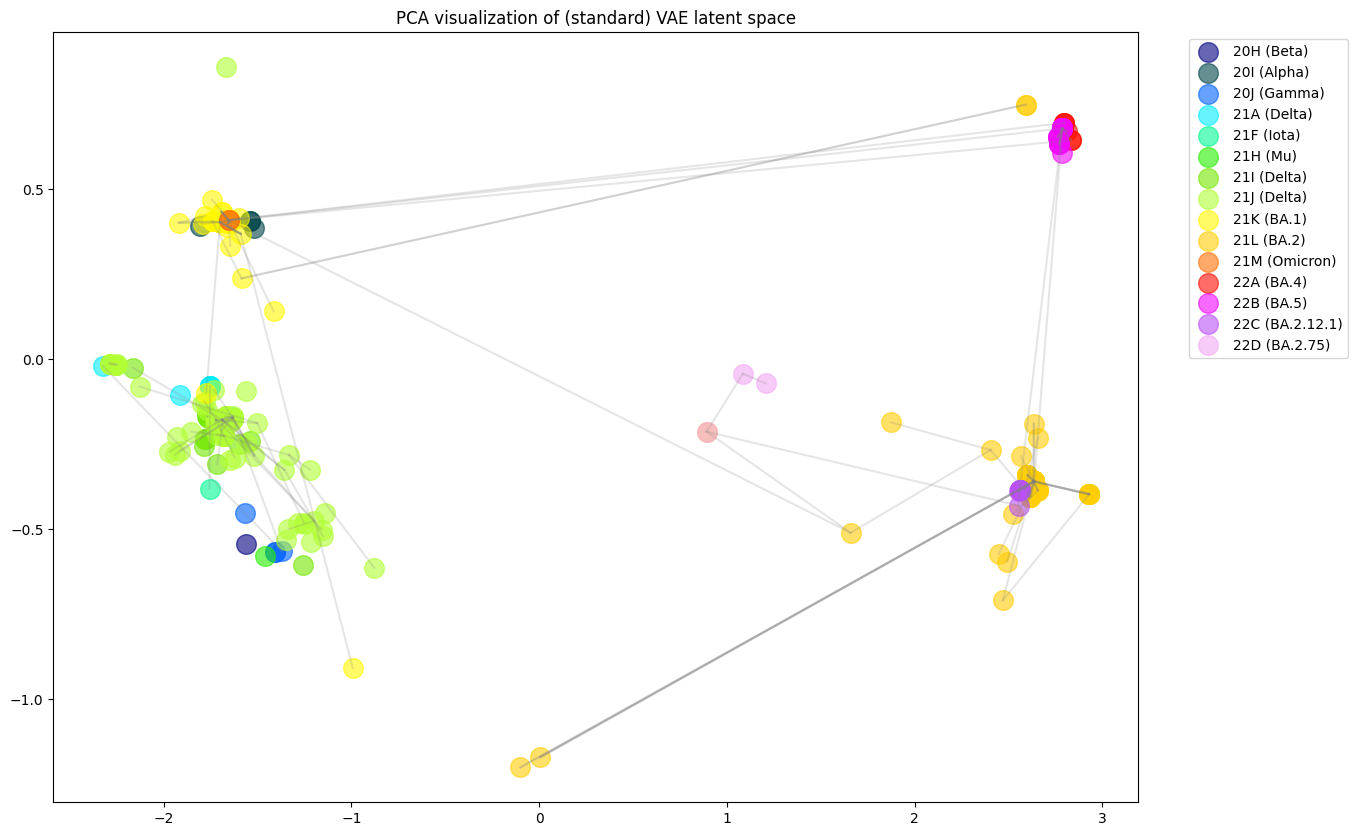

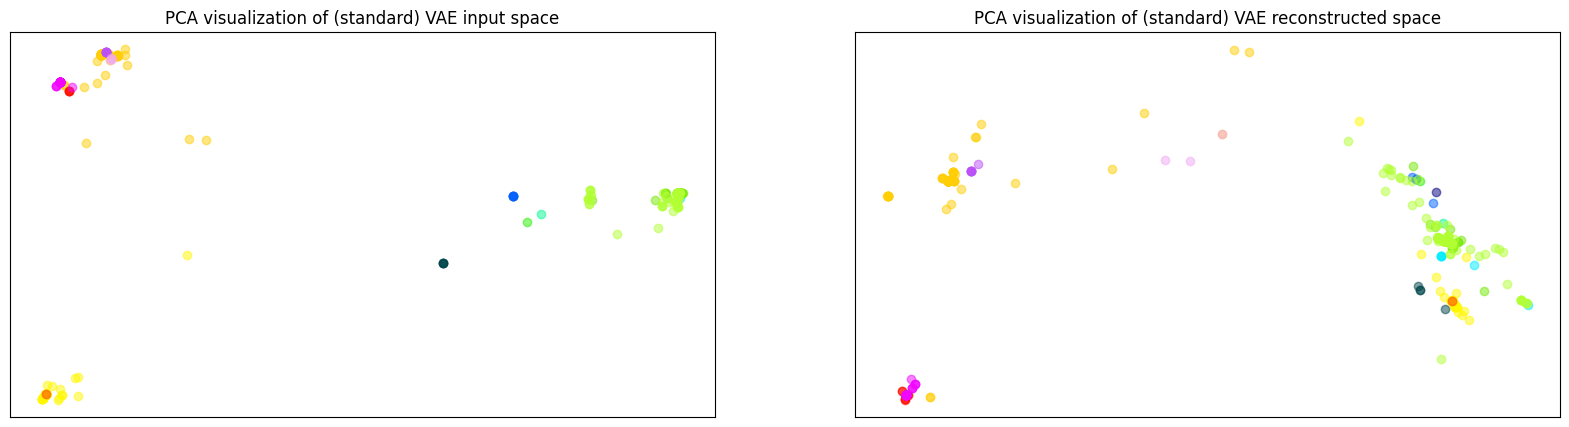

In [18]:
# import matplotlib.colors as mcolors
# import random
# colors = list(mcolors.TABLEAU_COLORS.keys())

cmap = plt.get_cmap("gist_ncar")
colors = [cmap(x) for x in np.arange(len(indexes)) / len(indexes)]

# colors = ['#%06X' % int(x) for x in np.linspace(0, 0xFFFFFF, num=len(indexes), endpoint=f)]
# random.seed(10)
# colors = []
# for i in range(len(indexes)):
#     colors.append('#%06X' % random.randint(0, 0xFFFFFF))

ranges = np.concatenate(indexes)

X = torch.tensor(new_dataset[ranges,:,:])
print("X shape")
print(new_dataset.shape)
print(X.shape)
# X = X.to(DEVICE)
X = X.view(X.size(0), -1).to(DEVICE)
pca = PCA(n_components=2, svd_solver="full")

fig,ax = plt.subplots(1,1,figsize=(14,10))
recon = None
with torch.no_grad():
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()

    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = recon.cpu().numpy()
    # Z_mean = Z_mean.cpu().numpy()
    
    print("\nRecon shape")
    print(recon.shape)
    
    # Z_embedded = tsne(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X = Z_mean)
    pca.fit(Z_mean)
    Z_embedded = pca.transform(Z_mean)
    variances = pca.explained_variance_ratio_
    tot = np.sum(variances)
    print(variances)
    print(f"total variance: {tot}")
    curr = 0
    for i,arr in enumerate(indexes):
        loc_arr = list(range(curr,curr + len(arr),1))
        # print(set([clade_labels[x] for x in ranges[loc_arr]]))
        ax.scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.6, color=colors[i], s=200)
        curr += len(arr)

    for p in pairs:
        ax.plot(Z_embedded[p,0], Z_embedded[p,1], color="gray", alpha=0.2)

l1 = 0.1
l2 = 0
ax.set_title("PCA visualization of (standard) VAE latent space")
ax.legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

fig,ax = plt.subplots(1,2,figsize=(20,5))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.axis("on")

ax[0].set_title("PCA visualization of (standard) VAE input space")
print("\n----------------\n")
pca = PCA(n_components=2)
pca.fit(X=X.cpu().numpy())
X_embedded = pca.transform(X=X.cpu().numpy())
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}\n")
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[0].scatter(X_embedded[loc_arr,0], X_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)

ax[1].set_title("PCA visualization of (standard) VAE reconstructed space")
pca = PCA(n_components=2)
pca.fit(X=recon)
recon_embedded = pca.transform(X=recon)
variances = pca.explained_variance_ratio_
tot = np.sum(variances)
print(variances)
print(f"total variance: {tot}")
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[1].scatter(recon_embedded[loc_arr,0], recon_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)
# ax[1].legend(bbox_to_anchor=(l1,l2,l1+1,l2+1)) 
plt.show()

## Riemannian metric

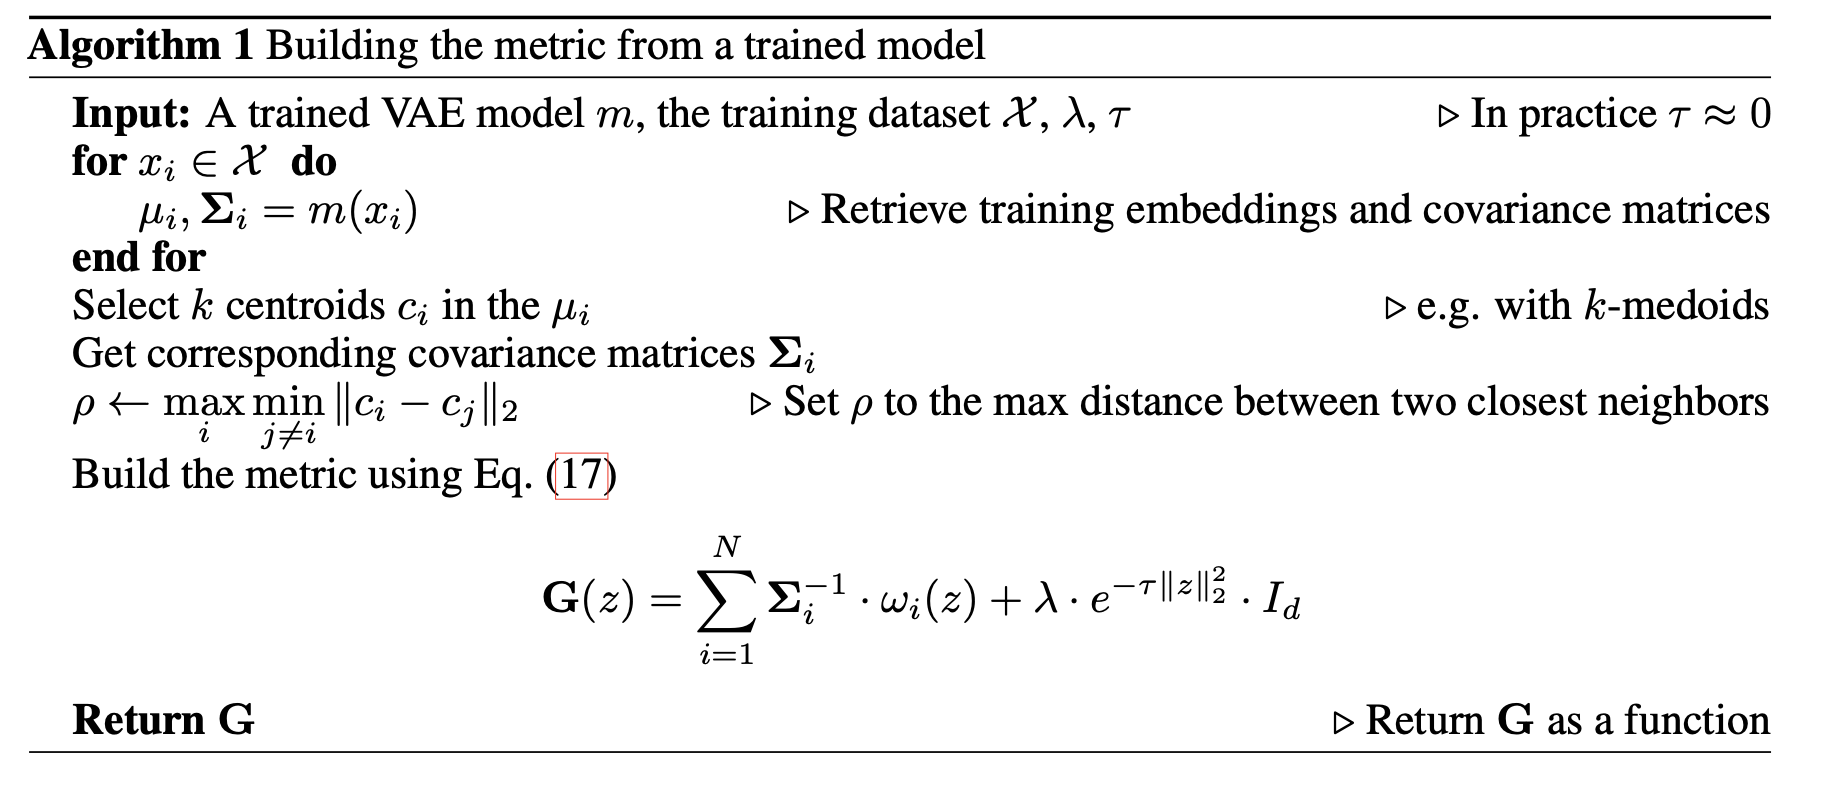

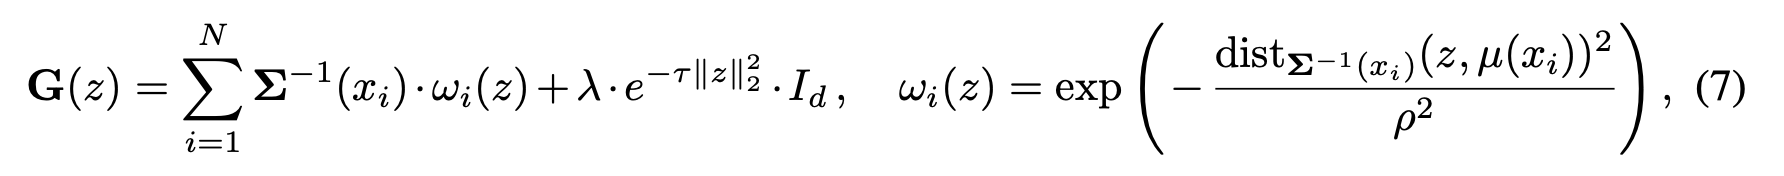

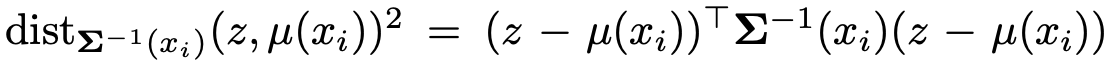

In [50]:
dset = ["training", "valid", "test"]
dset = dset[1]
abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
X = torch.tensor(new_dataset)
X = X.view(X.size(0), -1).to(DEVICE)

lamb = 0.1
k = len(new_dataset)
new_dataset = new_dataset[:k]

Z_mean = None
Z_std = None

with torch.no_grad():
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = recon.view(recon.shape[0], -1).cpu()
    Z_mean = Z_mean.cpu().numpy()
    Z_std = torch.exp(0.5 * Z_logvar).cpu().numpy()

# calculating rho
max_min_dist = 0
for i in range(len(new_dataset)):
    min_dist = float("inf")
    for j in range(i+1, len(new_dataset)):
        dist = np.linalg.norm(new_dataset[i,:] - new_dataset[j,:])
        if dist < min_dist: 
            min_dist = dist

    if min_dist > max_min_dist:
        max_min_dist = min_dist
rho = max_min_dist

print(Z_mean.shape)
dist_z = lambda z, mu_i, sigma_i: np.dot(np.multiply((z-mu_i), 1/sigma_i), (z-mu_i))
wi = lambda mu, sigma, rho, dist: lambda z, i: np.exp(-1/np.square(rho) * dist(z, mu[i,:], sigma[i,:]))
G = lambda w, sigma, lamb: lambda z: np.sum(np.multiply(1/sigma, np.array([w(z, i) for i in range(sigma.shape[0])])[:,np.newaxis]), axis=0) + lamb

G = G(wi(Z_mean, Z_std, rho, dist_z), Z_std, lamb)

(360, 50)


## Euclid vs Hamming

In [83]:
tot = 0
for N in range(new_dataset.shape[0]):
    X = torch.tensor(new_dataset[N:N+1])
    X = X.view(X.size(0), -1).to(DEVICE)
    # STANDARD
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    recon = vae_model.decoder.forward(Z_mean)
    recon = torch.exp(recon).detach().cpu().numpy()

    # BEDFORD
    # recon, Z_mean, Z_logvar = vae_model.forward(X)
    # recon = torch.nn.functional.softmax(recon.view(X.size(0), -1, len(ALPHABET)), dim=-1)
    # recon = recon.detach().cpu().numpy()
    # Z_mean = Z_mean.detach().cpu().numpy()

    X = X.view(X.size(0), -1, len(ALPHABET)).detach().cpu().numpy()
    X = np.argmax(X, axis=-1)
    recon = np.argmax(recon, axis=-1)
    tot += np.sum(np.not_equal(recon, X))

print("Average hamming dist between input sequence X and decoded sequence X'")
print(tot / new_dataset.shape[0])

Average hamming dist between input sequence X and decoded sequence X'
20.633333333333333


In [72]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}_spike.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
X = torch.tensor(new_dataset)
X_in = X.view(X.size(0), -1).to(DEVICE)

# STANDARD 
Z_mean, Z_logvar = vae_model.encoder.forward(X_in)
Z_mean = Z_mean.detach().cpu().numpy()

# BEDFORD
# recon, Z_mean, Z_logvar = vae_model.forward(X_in)
# recon = recon.detach().cpu().numpy()
# Z_mean = Z_mean.detach().cpu().numpy()

print(X.size(0))

genome = np.matmul(X.numpy(), np.array([1,2,3,4,5]))
print(X.size(1))
print(genome.shape[1])
hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i+1, X.size(0)):
        ham_d = np.sum(np.not_equal(genome[i,:],genome[j,:]))
        euclid_d = np.linalg.norm(Z_mean[i,:] - Z_mean[j,:])
        hamming_dists.append(ham_d)
        euclid_dists.append(euclid_d)



360
3822
3822


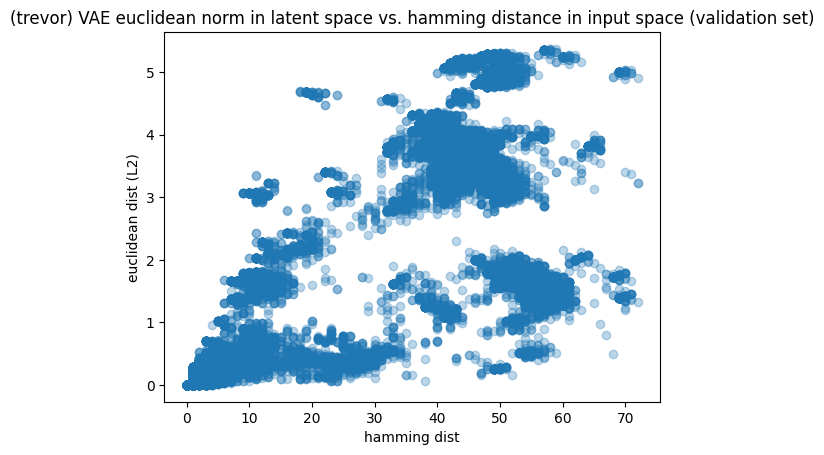

In [75]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("(standard) VAE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [74]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])

0.6692378492199766
